# Alzheimer's Disease Prediction - Feature Engineering Approach 1: Statistical Methods

This notebook implements feature engineering techniques using statistical approaches for feature selection and transformation for Alzheimer's disease prediction.

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# To display plots inline
%matplotlib inline

## 1. Data Loading and Preparation

In [5]:
# Load the dataset
data = pd.read_csv('../alzheimers_prediction_dataset.csv')

# Basic check of the data
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (74283, 25)


,Country,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,...,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
0,Spain,90,Male,1,33.0,Medium,Never,Occasionally,No,No,...,Healthy,High,Retired,Single,No,Low,Medium,High,Urban,No
1,Argentina,72,Male,7,29.9,Medium,Former,Never,No,No,...,Healthy,Medium,Unemployed,Widowed,No,High,Low,High,Urban,No
2,South Africa,86,Female,19,22.9,High,Current,Occasionally,No,Yes,...,Average,Medium,Employed,Single,No,Low,Medium,High,Rural,No
3,China,53,Male,17,31.2,Low,Never,Regularly,Yes,No,...,Healthy,Medium,Retired,Single,No,High,Medium,Low,Rural,No
4,Sweden,58,Female,3,30.0,High,Former,Never,Yes,No,...,Unhealthy,High,Employed,Married,No,Low,Medium,High,Rural,No


In [6]:
# Check if there are any missing values
missing_values = data.isnull().sum()
print("Missing values per column:")
missing_values[missing_values > 0]

Missing values per column:


Series([], dtype: int64)

In [7]:
# Categorize features
def categorize_features(df):
    # Define numerical features
    numerical_features = ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']
    
    # Define categorical features
    categorical_features = [col for col in df.columns if col not in numerical_features]
    
    # Define binary features
    binary_features = [
        'Gender', 'Diabetes', 'Hypertension', 'Cholesterol Level',
        'Family History of Alzheimer’s', 'Genetic Risk Factor (APOE-ε4 allele)',
        'Urban vs Rural Living', "Alzheimer’s Diagnosis"
    ]
    
    # Define ordinal features
    ordinal_features = [
        'Physical Activity Level', 'Depression Level', 'Sleep Quality',
        'Dietary Habits', 'Air Pollution Exposure', 'Social Engagement Level',
        'Income Level', 'Stress Levels'
    ]
    
    # Define nominal features (categorical features that are not ordinal or binary)
    nominal_features = [col for col in categorical_features if col not in binary_features and col not in ordinal_features]
    
    return numerical_features, categorical_features, binary_features, ordinal_features, nominal_features

numerical_features, categorical_features, binary_features, ordinal_features, nominal_features = categorize_features(data)

print("Numerical features:", numerical_features)
print("Binary features:", binary_features)
print("Ordinal features:", ordinal_features)
print("Nominal features:", nominal_features)

Numerical features: ['Age', 'Education Level', 'BMI', 'Cognitive Test Score']
Binary features: ['Gender', 'Diabetes', 'Hypertension', 'Cholesterol Level', 'Family History of Alzheimer’s', 'Genetic Risk Factor (APOE-ε4 allele)', 'Urban vs Rural Living', 'Alzheimer’s Diagnosis']
Ordinal features: ['Physical Activity Level', 'Depression Level', 'Sleep Quality', 'Dietary Habits', 'Air Pollution Exposure', 'Social Engagement Level', 'Income Level', 'Stress Levels']
Nominal features: ['Country', 'Smoking Status', 'Alcohol Consumption', 'Employment Status', 'Marital Status']


## 2. Feature Engineering

### 2.1 Encoding Categorical Variables

In [8]:
# Create a copy of the data for feature engineering
data_fe = data.copy()

# Binary encoding for binary variables
binary_mapping = {'No': 0, 'Yes': 1, 'Female': 0, 'Male': 1, 
                 'Normal': 0, 'High': 1, 'Rural': 0, 'Urban': 1}

for col in binary_features:
    data_fe[col] = data_fe[col].astype(str).str.lower().map({
        'no': 0, 'yes': 1, 'female': 0, 'male': 1,
        'normal': 0, 'high': 1, 'rural': 0, 'urban': 1
    })
    print(f"Encoded binary feature: {col}")

Encoded binary feature: Gender
Encoded binary feature: Diabetes
Encoded binary feature: Hypertension
Encoded binary feature: Cholesterol Level
Encoded binary feature: Family History of Alzheimer’s
Encoded binary feature: Genetic Risk Factor (APOE-ε4 allele)
Encoded binary feature: Urban vs Rural Living
Encoded binary feature: Alzheimer’s Diagnosis


In [9]:
# Ordinal encoding for ordinal variables
ordinal_mappings = {
    'Physical Activity Level': {'low': 0, 'medium': 1, 'high': 2},
    'Depression Level': {'low': 0, 'medium': 1, 'high': 2},
    'Sleep Quality': {'poor': 0, 'average': 1, 'good': 2},
    'Dietary Habits': {'unhealthy': 0, 'average': 1, 'healthy': 2},
    'Air Pollution Exposure': {'low': 0, 'medium': 1, 'high': 2},
    'Social Engagement Level': {'low': 0, 'medium': 1, 'high': 2},
    'Income Level': {'low': 0, 'medium': 1, 'high': 2},
    'Stress Levels': {'low': 0, 'medium': 1, 'high': 2},
    'Smoking Status': {'never': 0, 'former': 1, 'current': 2},
    'Alcohol Consumption': {'never': 0, 'occasionally': 1, 'regularly': 2}
}

for col, mapping in ordinal_mappings.items():
    if col in data_fe.columns:
        data_fe[col] = data_fe[col].astype(str).str.lower().map(mapping)
        print(f"Ordinally encoded: {col}")

Ordinally encoded: Physical Activity Level
Ordinally encoded: Depression Level
Ordinally encoded: Sleep Quality
Ordinally encoded: Dietary Habits
Ordinally encoded: Air Pollution Exposure
Ordinally encoded: Social Engagement Level
Ordinally encoded: Income Level
Ordinally encoded: Stress Levels
Ordinally encoded: Smoking Status
Ordinally encoded: Alcohol Consumption


In [10]:
# One-hot encoding for nominal variables
nominal_columns = ['Country', 'Employment Status', 'Marital Status']
data_fe = pd.get_dummies(data_fe, columns=nominal_columns, drop_first=True)
print("Applied one-hot encoding to nominal features:", nominal_columns)

Applied one-hot encoding to nominal features: ['Country', 'Employment Status', 'Marital Status']


In [11]:
# Check the shape of the encoded data
print(f"Shape after encoding: {data_fe.shape}")
data_fe.head()

Shape after encoding: (74283, 45)


,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,...,Country_South Africa,Country_South Korea,Country_Spain,Country_Sweden,Country_UK,Country_USA,Employment Status_Retired,Employment Status_Unemployed,Marital Status_Single,Marital Status_Widowed
0,90,1,1,33.0,1,0,1,0,0,0,...,False,False,True,False,False,False,True,False,True,False
1,72,1,7,29.9,1,1,0,0,0,0,...,False,False,False,False,False,False,False,True,False,True
2,86,0,19,22.9,2,2,1,0,1,0,...,True,False,False,False,False,False,False,False,True,False
3,53,1,17,31.2,0,0,2,1,0,0,...,False,False,False,False,False,False,True,False,True,False
4,58,0,3,30.0,2,1,0,1,0,0,...,False,False,False,True,False,False,False,False,False,False


### 2.2 Standardization of Numerical Features

In [12]:
# Standardize numerical features
scaler = StandardScaler()
data_fe[numerical_features] = scaler.fit_transform(data_fe[numerical_features])
print("Standardized numerical features")
data_fe.head()

Standardized numerical features


,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,...,Country_South Africa,Country_South Korea,Country_Spain,Country_Sweden,Country_UK,Country_USA,Employment Status_Retired,Employment Status_Unemployed,Marital Status_Single,Marital Status_Widowed
0,1.389398,1,-1.474299,1.305314,1,0,1,0,0,0,...,False,False,True,False,False,False,True,False,True,False
1,0.002719,1,-0.432087,0.654689,1,1,0,0,0,0,...,False,False,False,False,False,False,False,True,False,True
2,1.081247,0,1.652339,-0.814465,2,2,1,0,1,0,...,True,False,False,False,False,False,False,False,True,False
3,-1.460997,1,1.304935,0.927532,0,0,2,1,0,0,...,False,False,False,False,False,False,True,False,True,False
4,-1.075808,0,-1.126895,0.675677,2,1,0,1,0,0,...,False,False,False,True,False,False,False,False,False,False


### 2.3 Feature Interaction and Creation

In [13]:
# Create interaction terms
# Age x Genetic Risk Factor interaction (important for Alzheimer's risk)
data_fe['Age_x_APOE'] = data_fe['Age'] * data_fe['Genetic Risk Factor (APOE-ε4 allele)']
print("Created interaction term: Age_x_APOE")

# Cognitive Score x Age interaction
data_fe['CognitiveScore_x_Age'] = data_fe['Cognitive Test Score'] * data_fe['Age']
print("Created interaction term: CognitiveScore_x_Age")

# Physical Activity x Age interaction
data_fe['PhysicalActivity_x_Age'] = data_fe['Physical Activity Level'] * data_fe['Age']
print("Created interaction term: PhysicalActivity_x_Age")

# Family History x Genetic Risk interaction
data_fe['FamilyHistory_x_APOE'] = data_fe['Family History of Alzheimer’s'] * data_fe['Genetic Risk Factor (APOE-ε4 allele)']
print("Created interaction term: FamilyHistory_x_APOE")

# Overall Health Index (combines several health indicators)
data_fe['Health_Index'] = (data_fe['Physical Activity Level'] + 
                          data_fe['Sleep Quality'] + 
                          data_fe['Dietary Habits'] - 
                          data_fe['Stress Levels'])
print("Created composite feature: Health_Index")

# Risk Factor Count (counts presence of known risk factors)
data_fe['Risk_Factor_Count'] = (data_fe['Diabetes'] + 
                               data_fe['Hypertension'] + 
                               data_fe['Cholesterol Level'] + 
                               data_fe['Family History of Alzheimer’s'] +
                               data_fe['Genetic Risk Factor (APOE-ε4 allele)'])
print("Created composite feature: Risk_Factor_Count")

Created interaction term: Age_x_APOE
Created interaction term: CognitiveScore_x_Age
Created interaction term: PhysicalActivity_x_Age
Created interaction term: FamilyHistory_x_APOE
Created composite feature: Health_Index
Created composite feature: Risk_Factor_Count


In [14]:
# Check the dataset after creating interaction terms
print(f"Dataset shape after feature creation: {data_fe.shape}")
data_fe.head()

Dataset shape after feature creation: (74283, 51)


,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,...,Employment Status_Retired,Employment Status_Unemployed,Marital Status_Single,Marital Status_Widowed,Age_x_APOE,CognitiveScore_x_Age,PhysicalActivity_x_Age,FamilyHistory_x_APOE,Health_Index,Risk_Factor_Count
0,1.389398,1,-1.474299,1.305314,1,0,1,0,0,0,...,True,False,True,False,0.0,1.747389,1.389398,0,1,0
1,0.002719,1,-0.432087,0.654689,1,1,0,0,0,0,...,False,True,False,True,0.0,0.000047,0.002719,0,3,0
2,1.081247,0,1.652339,-0.814465,2,2,1,0,1,0,...,False,False,True,False,0.0,-1.161785,2.162494,0,3,1
3,-1.460997,1,1.304935,0.927532,0,0,2,1,0,0,...,True,False,True,False,-0.0,-1.184983,-0.000000,0,3,1
4,-1.075808,0,-1.126895,0.675677,2,1,0,1,0,0,...,False,False,False,False,-0.0,0.835651,-2.151617,0,0,1


## 3. Statistical Feature Selection

In [15]:
# Separate features and target
X = data_fe.drop(columns=["Alzheimer’s Diagnosis"])
y = data_fe["Alzheimer’s Diagnosis"]

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (74283, 50), y shape: (74283,)


Top 20 Features by Correlation with Target:
Age                                     0.419923
PhysicalActivity_x_Age                  0.323367
Genetic Risk Factor (APOE-ε4 allele)    0.194484
Age_x_APOE                              0.188766
FamilyHistory_x_APOE                    0.148406
Risk_Factor_Count                       0.143904
Family History of Alzheimer’s           0.140885
Country_Russia                          0.042795
Country_India                           0.042032
Country_South Africa                    0.038333
Country_Japan                           0.034692
Country_Brazil                          0.034295
Country_Canada                          0.033547
Country_Sweden                          0.033126
Country_Mexico                          0.032645
Country_Norway                          0.029667
Country_China                           0.012380
Country_USA                             0.011442
Country_Italy                           0.009361
Country_Spain            

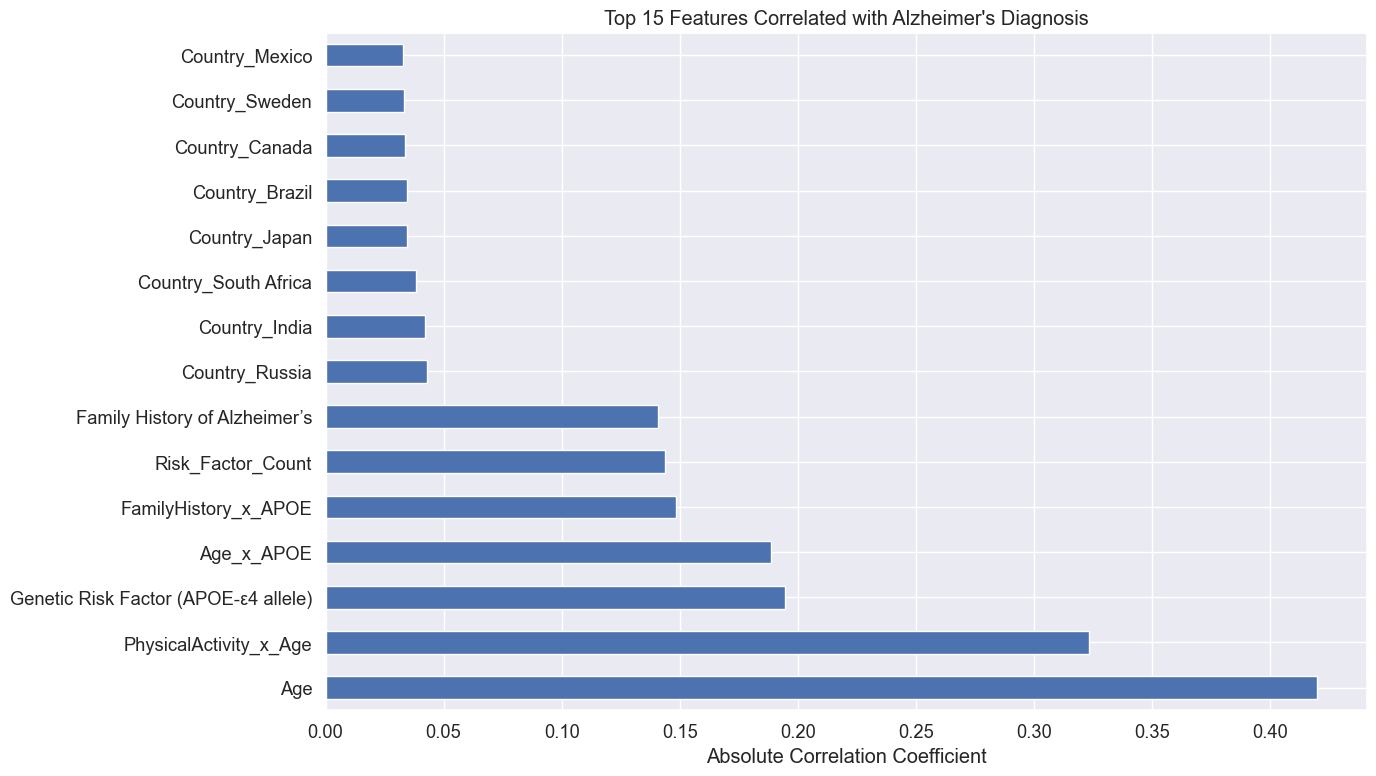

In [16]:
# Calculate correlation with target
correlation_with_target = X.apply(lambda x: x.corr(y))
correlation_sorted = correlation_with_target.abs().sort_values(ascending=False)

# Display top 20 features by correlation
print("Top 20 Features by Correlation with Target:")
print(correlation_sorted[:20])

# Visualize top 15 correlations
plt.figure(figsize=(14, 8))
correlation_sorted[:15].plot(kind='barh')
plt.title('Top 15 Features Correlated with Alzheimer\'s Diagnosis')
plt.xlabel('Absolute Correlation Coefficient')
plt.tight_layout()
plt.show()

### 3.1 Mutual Information for Feature Selection

/opt/homebrew/Caskroom/miniconda/base/envs/dlt_labs/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


Top 20 Features by Mutual Information:
CognitiveScore_x_Age                    0.110828
Age                                     0.105895
PhysicalActivity_x_Age                  0.070563
Age_x_APOE                              0.040016
Genetic Risk Factor (APOE-ε4 allele)    0.018661
FamilyHistory_x_APOE                    0.010910
Risk_Factor_Count                       0.010460
Family History of Alzheimer’s           0.009842
Cognitive Test Score                    0.001244
Country_Russia                          0.000902
Country_India                           0.000870
Country_South Africa                    0.000725
Country_Japan                           0.000614
Country_Brazil                          0.000581
Country_Canada                          0.000574
Country_Sweden                          0.000560
Country_Mexico                          0.000526
Country_Norway                          0.000448
Education Level                         0.000201
Country_China                 

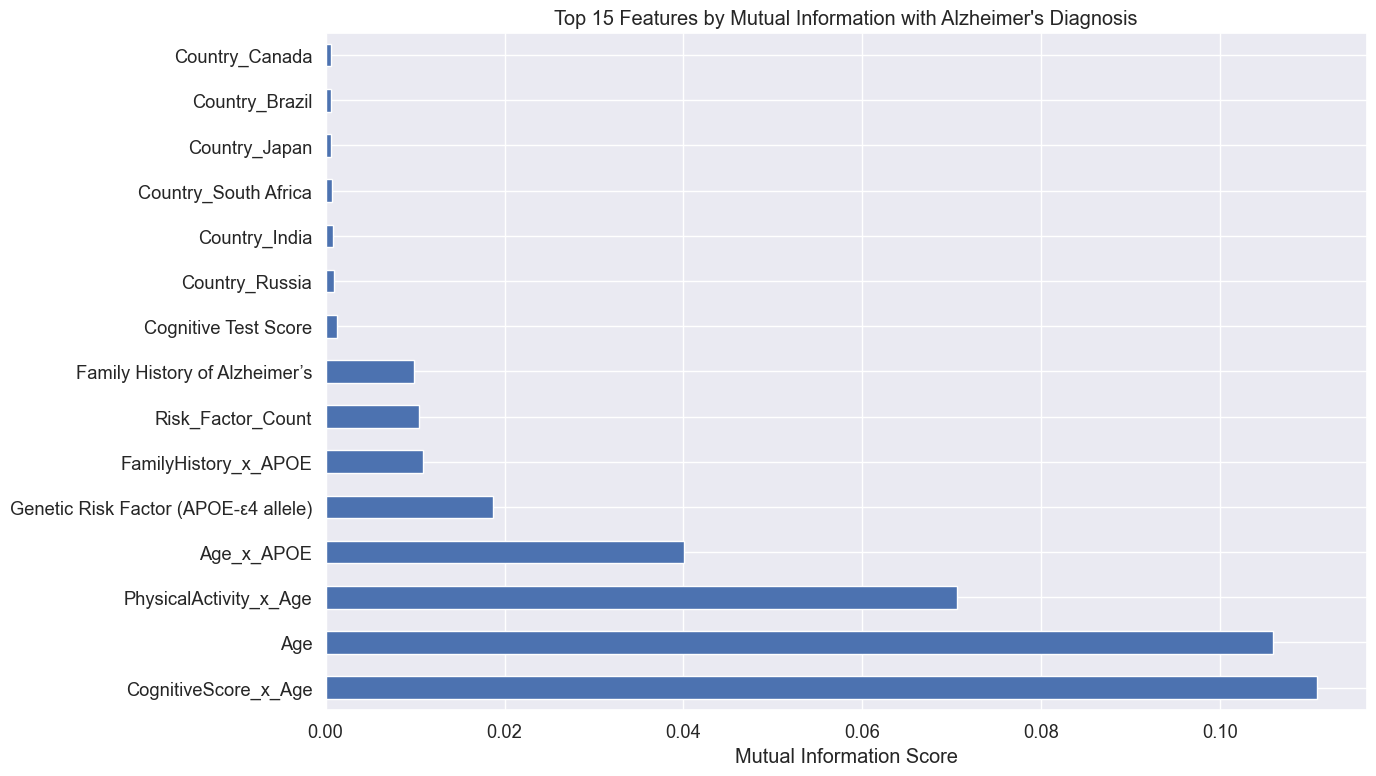

In [17]:
# Calculate mutual information scores
# First, determine which features are discrete
discrete_mask = []
for col in X.columns:
    # If number of unique values is small, consider it discrete
    if X[col].nunique() < 21:
        discrete_mask.append(True)
    else:
        discrete_mask.append(False)

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features=discrete_mask, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Display top 20 features by mutual information
print("Top 20 Features by Mutual Information:")
print(mi_series[:20])

# Visualize top 15 features by mutual information
plt.figure(figsize=(14, 8))
mi_series[:15].plot(kind='barh')
plt.title('Top 15 Features by Mutual Information with Alzheimer\'s Diagnosis')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.show()

### 3.2 Chi-Square Test for Categorical Features

No categorical features found after encoding

Top 20 Features by Chi-Square Test:
Age                                     7309.092019
PhysicalActivity_x_Age                  3719.907791
Genetic Risk Factor (APOE-ε4 allele)    2252.840897
FamilyHistory_x_APOE                    1539.232291
Risk_Factor_Count                       1116.283247
Family History of Alzheimer’s           1032.199803
Age_x_APOE                               294.236057
Country_Russia                           129.121723
Country_India                            124.624198
Country_South Africa                     103.626030
Country_Japan                             84.889753
Country_Brazil                            82.850532
Country_Canada                            79.420150
Country_Sweden                            77.464392
Country_Mexico                            75.327492
Country_Norway                            62.118178
Country_China                             10.833831
Country_USA                       

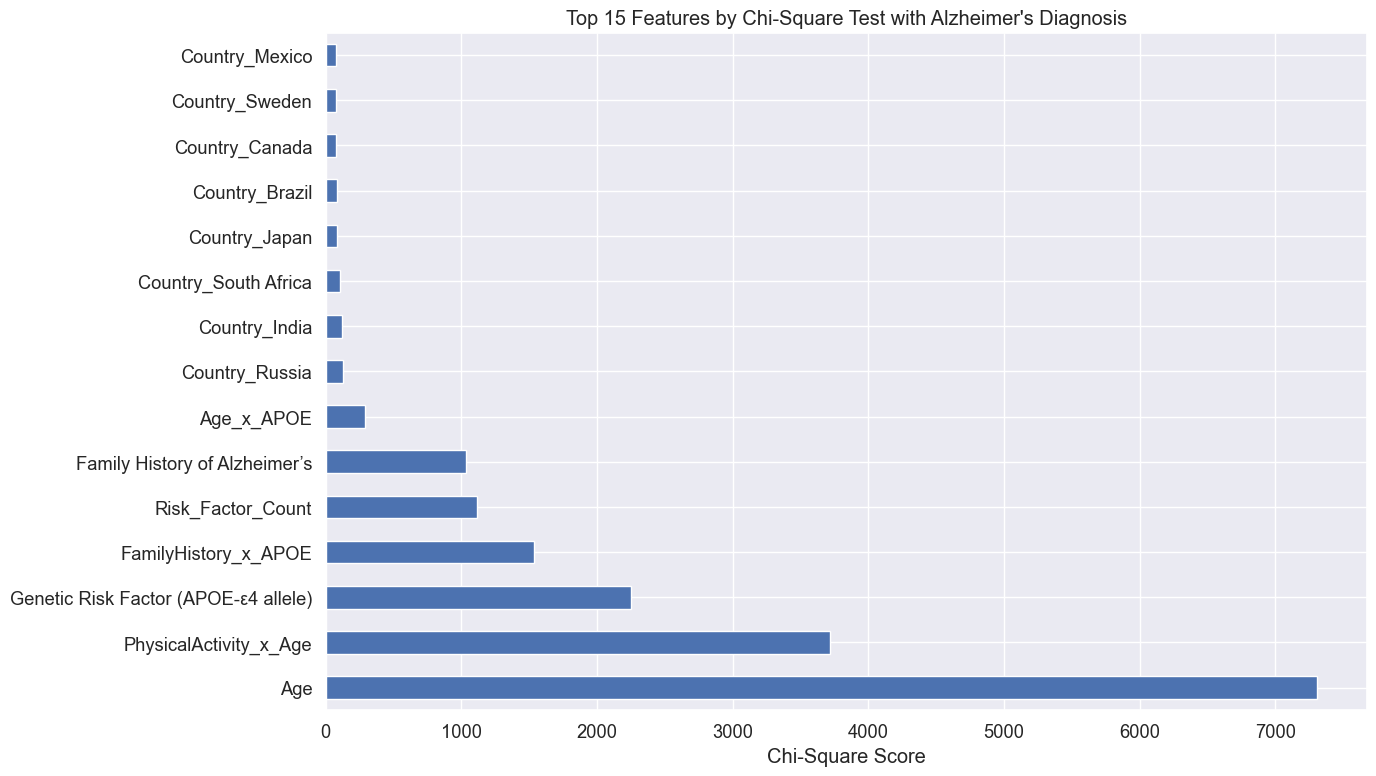

In [18]:
# Identify categorical columns in X
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# We'll use chi-square test for categorical features
if categorical_cols:
    print("Performing chi-square test for categorical features...")
else:
    print("No categorical features found after encoding")
    
# Ensure all features are positive (requirement for chi2)
# Convert X to DataFrame if it's not already
X_positive = X.copy()
for col in X_positive.columns:
    if X_positive[col].min() < 0:
        # Add the absolute minimum to make all values positive
        X_positive[col] = X_positive[col] - X_positive[col].min() + 0.1

# Apply chi-square test
chi2_scores = SelectKBest(chi2, k='all').fit(X_positive, y)
chi2_series = pd.Series(chi2_scores.scores_, index=X.columns).sort_values(ascending=False)

# Display top 20 features by chi-square
print("\nTop 20 Features by Chi-Square Test:")
print(chi2_series[:20])

# Visualize top 15 features by chi-square
plt.figure(figsize=(14, 8))
chi2_series[:15].plot(kind='barh')
plt.title('Top 15 Features by Chi-Square Test with Alzheimer\'s Diagnosis')
plt.xlabel('Chi-Square Score')
plt.tight_layout()
plt.show()

### 3.3 Mann-Whitney U Test for Numerical Features

Mann-Whitney U Test Results for Numerical Features:
                  Feature  U Statistic   p-value   -log(p)
0                     Age  998488536.0  0.000000       inf
4              Age_x_APOE  771561910.5  0.000000       inf
6  PhysicalActivity_x_Age  933837101.0  0.000000       inf
7    FamilyHistory_x_APOE  716655254.5  0.000000       inf
9       Risk_Factor_Count  773469457.0  0.000000       inf
1         Education Level  672010250.0  0.308469  0.510789
8            Health_Index  666300974.0  0.325841  0.486994
2                     BMI  667750996.0  0.643575  0.191401
3    Cognitive Test Score  668187672.0  0.755795  0.121596
5    CognitiveScore_x_Age  669563806.0  0.867247  0.061857


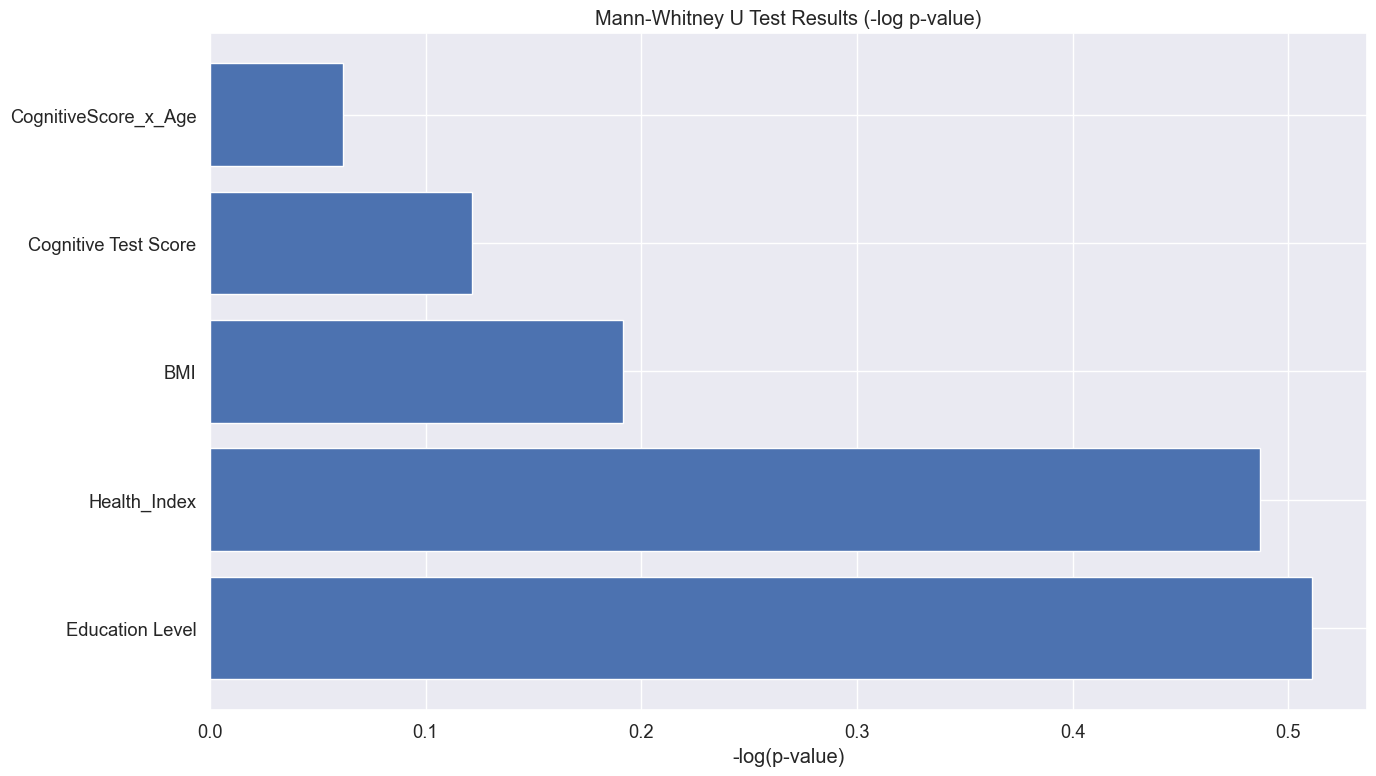

In [19]:
# Create a DataFrame to store Mann-Whitney results
u_test_results = []

# Perform Mann-Whitney U test for each numerical feature
for feature in numerical_features + ['Age_x_APOE', 'CognitiveScore_x_Age', 'PhysicalActivity_x_Age',
                                     'FamilyHistory_x_APOE', 'Health_Index', 'Risk_Factor_Count']:
    try:
        # Split the feature into two groups based on Alzheimer's diagnosis
        yes_group = data_fe[data_fe["Alzheimer’s Diagnosis"] == 1][feature]
        no_group = data_fe[data_fe["Alzheimer’s Diagnosis"] == 0][feature]
        
        # Perform Mann-Whitney U test
        u_stat, p_value = mannwhitneyu(yes_group, no_group, alternative='two-sided')
        
        # Store results
        u_test_results.append({
            'Feature': feature,
            'U Statistic': u_stat,
            'p-value': p_value,
            '-log(p)': -np.log10(p_value) if p_value > 0 else np.inf
        })
    except Exception as e:
        print(f"Error performing Mann-Whitney U test for {feature}: {e}")

# Convert to DataFrame and sort by p-value
u_test_df = pd.DataFrame(u_test_results).sort_values(by='p-value')
print("Mann-Whitney U Test Results for Numerical Features:")
print(u_test_df)

# Visualize -log(p) values
plt.figure(figsize=(14, 8))
plt.barh(u_test_df['Feature'], u_test_df['-log(p)'])
plt.title('Mann-Whitney U Test Results (-log p-value)')
plt.xlabel('-log(p-value)')
plt.tight_layout()
plt.show()

## 4. Selecting the Final Feature Set

In [20]:
# Combine insights from different feature selection methods

# Get top features from each method
top_corr_features = correlation_sorted[:20].index.tolist()
top_mi_features = mi_series[:20].index.tolist()
top_chi2_features = chi2_series[:20].index.tolist()
top_mw_features = u_test_df['Feature'][:10].tolist()

# Find common features across multiple methods
common_features = set()
all_features = set(top_corr_features + top_mi_features + top_chi2_features + top_mw_features)

for feature in all_features:
    methods_count = 0
    if feature in top_corr_features:
        methods_count += 1
    if feature in top_mi_features:
        methods_count += 1
    if feature in top_chi2_features:
        methods_count += 1
    if feature in top_mw_features:
        methods_count += 1
    
    # If the feature appears in at least 2 methods, include it
    if methods_count >= 2:
        common_features.add(feature)

# Add a few domain-specific features we know are important
domain_important_features = [
    'Age', 'Cognitive Test Score', 'Genetic Risk Factor (APOE-ε4 allele)',
    'Family History of Alzheimer’s', 'Age_x_APOE', 'Risk_Factor_Count'
]

for feature in domain_important_features:
    if feature in X.columns:
        common_features.add(feature)

# Convert set to list for final feature selection
selected_features = list(common_features)
print(f"Selected {len(selected_features)} features:")
for feature in sorted(selected_features):
    print(f"- {feature}")

Selected 23 features:
- Age
- Age_x_APOE
- Cognitive Test Score
- CognitiveScore_x_Age
- Country_Brazil
- Country_Canada
- Country_China
- Country_India
- Country_Italy
- Country_Japan
- Country_Mexico
- Country_Norway
- Country_Russia
- Country_South Africa
- Country_Spain
- Country_Sweden
- Country_USA
- Education Level
- Family History of Alzheimer’s
- FamilyHistory_x_APOE
- Genetic Risk Factor (APOE-ε4 allele)
- PhysicalActivity_x_Age
- Risk_Factor_Count


Final dataset shape: (74283, 23)


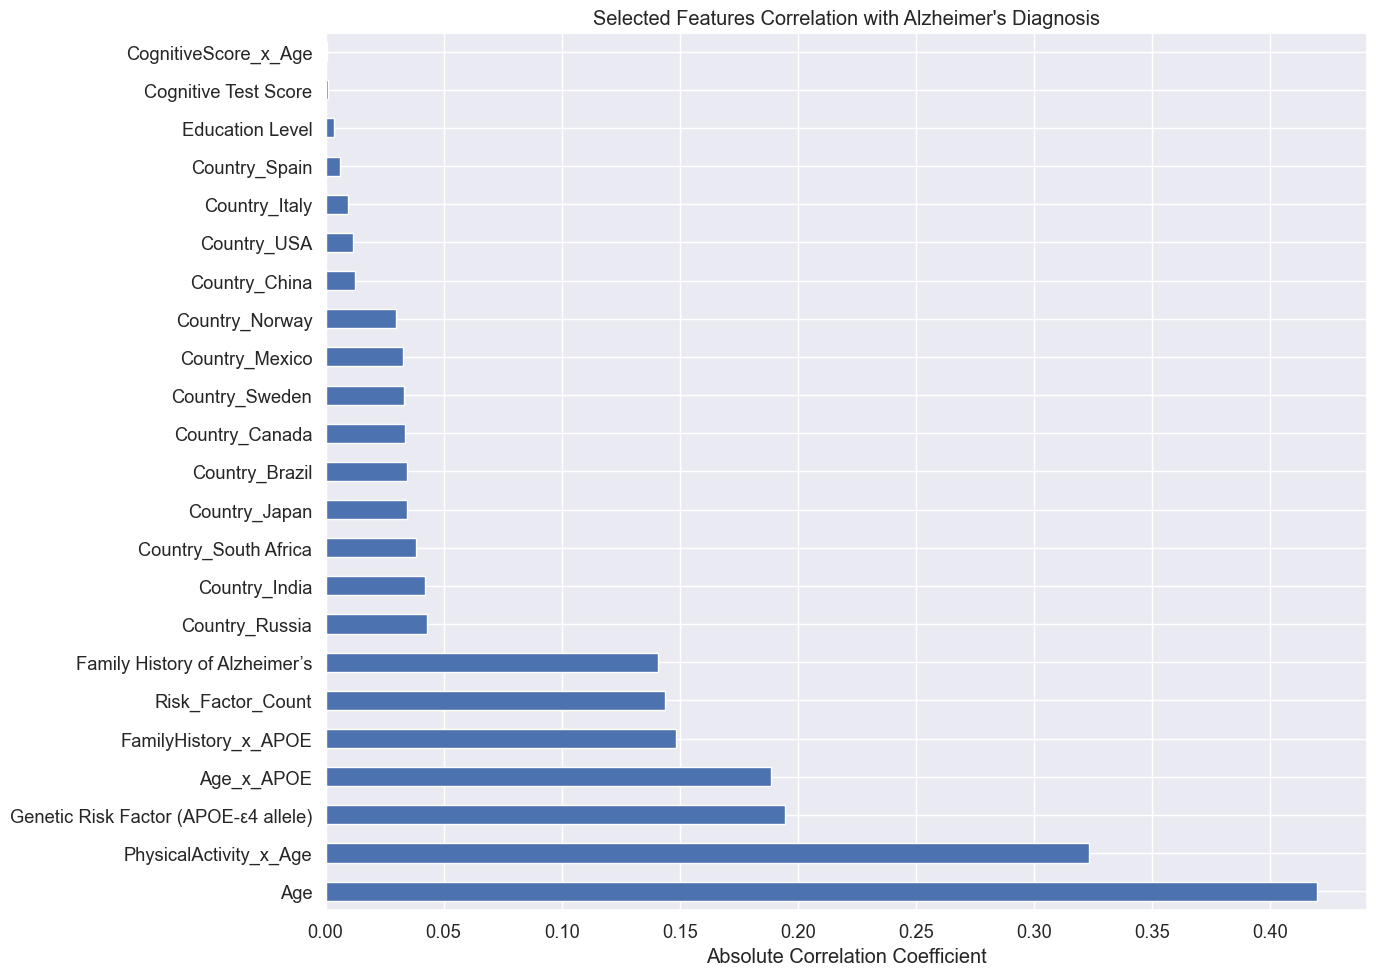

In [21]:
# Create the final dataset with selected features
X_selected = X[selected_features]
print(f"Final dataset shape: {X_selected.shape}")

# Look at feature importance based on correlation again, but only for selected features
correlation_selected = X_selected.apply(lambda x: x.corr(y)).abs().sort_values(ascending=False)

# Visualize selected features by correlation
plt.figure(figsize=(14, 10))
correlation_selected.plot(kind='barh')
plt.title('Selected Features Correlation with Alzheimer\'s Diagnosis')
plt.xlabel('Absolute Correlation Coefficient')
plt.tight_layout()
plt.show()

## 5. Save the Engineered Dataset

In [22]:
# Create the final dataset with target
final_data = X_selected.copy()
final_data["Alzheimer's Diagnosis"] = y

# Save the dataset
final_data.to_csv("fe_statistical_approach.csv", index=False)
print("Feature-engineered dataset saved as 'fe_statistical_approach.csv'")

Feature-engineered dataset saved as 'fe_statistical_approach.csv'


## 6. Summary of Feature Engineering Approach

In this notebook, we applied several statistical feature engineering techniques:

1. **Data Encoding**:
   - Binary encoding for binary features
   - Ordinal encoding for ordinal features
   - One-hot encoding for nominal features

2. **Numerical Feature Processing**:
   - Standardization to put all features on the same scale

3. **Feature Creation**:
   - Interaction terms including Age_x_APOE and CognitiveScore_x_Age
   - Composite features like Health_Index and Risk_Factor_Count

4. **Statistical Feature Selection**:
   - Correlation analysis
   - Mutual information
   - Chi-square test
   - Mann-Whitney U test

5. **Final Feature Selection**:
   - Combined multiple statistical methods to identify the most important features
   - Added domain-specific important features

This approach focused on using statistical methods to identify the most predictive features for Alzheimer's disease. The resulting feature set can be used for modeling in subsequent notebooks.